# Мобильные приложения — Выделение групп пользователей на основе поведения

**Описание проекта**

Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

**Описание данных**

Датасет **mobile_dataset.csv** содержит колонки:

- `event.time` — время совершения
- `event.name` — название события 
- `user.id` — идентификатор пользователя

Датасет **mobile_sources.csv** содержит колонки:

- `userId` — идентификатор пользователя
- `source` — источник, с которого пользователь установил приложение

Расшифровка событий:

- `advert_open` — открытие карточки объявления
- `photos_show` — просмотр фотографий в объявлении
- `tips_show` — пользователь увидел рекомендованные объявления
- `tips_click` — пользователь кликнул по рекомендованному объявлению
- `contacts_show` и `show_contacts` — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
- `contacts_call` — пользователь позвонил по номеру телефона на карточке объявления
- `map` — пользователь открыл карту размещенных объявлений
- `search_1` — `search_7` — разные события, связанные с поиском по сайту
- `favorites_add` — добавление объявления в избранное

**Задачи исследования**

Выбрать методику сегментации пользователей и ответить на вопросы заказчика в разрезе выделенных групп
1. Пользователи какой группы склонны часто возвращаться в мобильное приложение (Retention rate)?
2. Пользователи какой группы часто делают целевое событие (конверсия в целевое действие)?
3. Как различается время между распространенными событиями пользователей из разных групп?

##  Изучение общей информации. Подготовка данных.

In [1]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns
import plotly.express as px
import warnings 
warnings.filterwarnings('ignore')
from pylab import rcParams
from datetime import datetime, timedelta, time
from scipy import stats as st 
import numpy as np 
import math as mth 

In [2]:
mobile_sourсes = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')
mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')

In [3]:
display(mobile_sourсes.head()) #получение первых 5 строк таблицы mobile_sourсes
print()
display(mobile_sourсes.info()) #получение общей информации о данных в таблице mobile_sourсes
print()
mobile_sourсes.duplicated().sum() #проверяем дубликаты

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


None

0

In [4]:
display(mobile_dataset.head()) #получение первых 5 строк таблицы mobile_dataset
print()
display(mobile_dataset.info()) #получение общей информации о данных в таблице mobile_dataset
print()
mobile_dataset.duplicated().sum() #проверяем дубликаты

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


None

0

In [5]:
#переименовываем названия столбцов
mobile_dataset.rename(columns = \
    {'event.name':'event_name', \
     'event.time' : 'event_time', \
     'user.id': 'user_id'}, inplace = True)

#переименовываем названия столбцов
mobile_sourсes.rename(columns = {'userId':'user_id'}, inplace = True)

In [6]:
#меняем формат данных в столбце event_time
mobile_dataset['event_time'] = pd.to_datetime(mobile_dataset['event_time'], format='%Y-%m-%d %H:%M:%S')
mobile_dataset['event_time'] = mobile_dataset['event_time'].dt.strftime("%Y-%m-%d %H:%M:%S")
mobile_dataset['event_time'] = pd.to_datetime(mobile_dataset['event_time'])

При первом ознакомлении с данными не было обнаружено пропусков или дубликатов. В ходе предобработки мы исправили тип данных в столбце `event_time`, а также переименовали названия стобцов.

## Проведение исследовательского анализа данных (EDA).

Для дальнейшого анализа соединим таблицы mobile_dataset и mobile_sourсes в одну методом merge.

In [7]:
df = mobile_dataset.merge(mobile_sourсes, on='user_id', how='left')
df.head()

,event_time,event_name,user_id,source
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex


In [8]:
df.groupby('event_name').agg({'user_id': 'count'}).sort_values(by='user_id', ascending= False).reset_index()

,event_name,user_id
0,tips_show,40055
1,photos_show,10012
2,advert_open,6164
3,contacts_show,4450
4,map,3881
5,search_1,3506
6,favorites_add,1417
7,search_5,1049
8,tips_click,814
9,search_4,701


Из описания данных мы знаем, что события `show_contacts` и `contacts_show` имеют одинановое значение, поэтому соединим их в одно событие `contacts_show`. Также у нас есть 7 разных событий `search`, так как мы не знаем точные действия, которые совершают пользователи под этими событиями, объединим их в одно общее событие `search`.

In [9]:
df.loc[df['event_name']== 'show_contacts', 'event_name'] = 'contacts_show'
df.loc[df['event_name']== 'search_1', 'event_name'] = 'search'
df.loc[df['event_name']== 'search_2', 'event_name'] = 'search'
df.loc[df['event_name']== 'search_3', 'event_name'] = 'search'
df.loc[df['event_name']== 'search_4', 'event_name'] = 'search'
df.loc[df['event_name']== 'search_5', 'event_name'] = 'search'
df.loc[df['event_name']== 'search_6', 'event_name'] = 'search'
df.loc[df['event_name']== 'search_7', 'event_name'] = 'search'

После объединения событий проверим таблицу еще раз на наличие дубликатов.

In [10]:
df.duplicated().sum()

1224

Появилось 1224 явных дубликата, удалим их из дальнейшего исследования.

In [11]:
df = df.drop_duplicates().reset_index(drop=True) 
df.duplicated().sum() 

0

In [12]:
t = df.groupby('event_name').agg({'user_id': 'count'}).sort_values(by='user_id', ascending= False)
t

,user_id
event_name,
tips_show,39907
photos_show,9352
search,6684
advert_open,6146
contacts_show,4376
map,3749
favorites_add,1414
tips_click,811
contacts_call,534


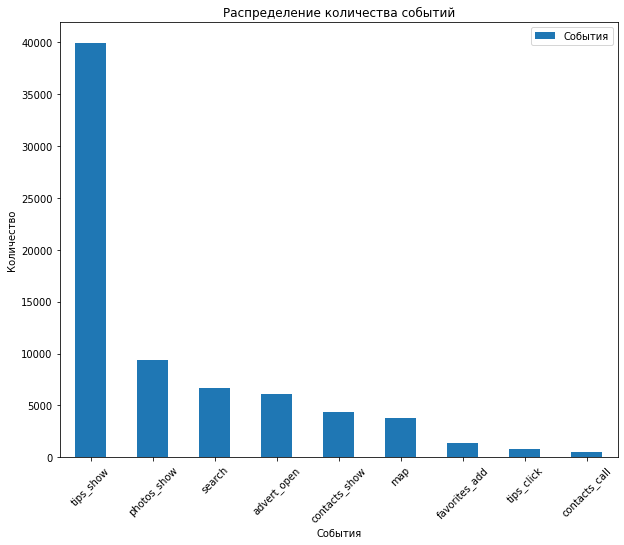

In [13]:
t.plot.bar(figsize=(10,8))
plt.xticks(rotation=45)
#строим гистограмму по событиям
plt.title('Распределение количества событий')
plt.legend(['Cобытия'])
plt.xlabel('События')
plt.ylabel('Количество')
plt.show()

Чаще всего встречается событие `tips_show`, которое занимает больше пололовины всех событий. Далее следует `photos_show` и объединенные события по поиску в приложении. Целевое действие `contacts_show` насчитывает 4529 событий.

Посмотрим на количество совершенных событий и уникальных пользователей на каждый день.

In [14]:
df['date'] = df['event_time'].dt.date #добавляем столбец только с датой в датафрейм
df.groupby(['date'])['user_id'].agg(['count', 'nunique']).reset_index()

,date,count,nunique
0,2019-10-07,2518,204
1,2019-10-08,2453,204
2,2019-10-09,2010,227
3,2019-10-10,2222,233
4,2019-10-11,1951,206
5,2019-10-12,1809,178
6,2019-10-13,2605,226
7,2019-10-14,3003,298
8,2019-10-15,2671,303
9,2019-10-16,2676,278


In [15]:
print('Всего событий:', df['event_name'].count())
print('Количество уникальных пользователей:' ,df['user_id'].nunique())
print('В среднем приходится на одного пользователя событий:', (df['event_name'].count() / df['user_id'].nunique()).round(2))
print('Доля пользователей, которые хоть раз совершали событие:', round(100 - df['user_id'].nunique() / df['user_id'].count()* 100, 2))
print('Минимальная дата:', df['event_time'].min()) 
print('Максимальная дата:', df['event_time'].max()) 

Всего событий: 72973
Количество уникальных пользователей: 4293
В среднем приходится на одного пользователя событий: 17.0
Доля пользователей, которые хоть раз совершали событие: 94.12
Минимальная дата: 2019-10-07 00:00:00
Максимальная дата: 2019-11-03 23:58:12


Проверим, как распределяются события по пользователям.

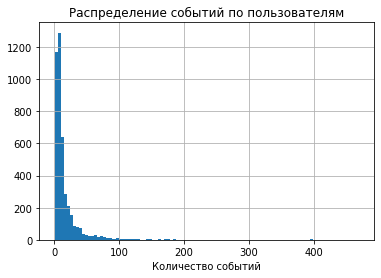

In [16]:
users_df = df.groupby('user_id').agg({'event_name': 'count'})
users_df.hist(bins=100) #строим гистограмму распределения 
rcParams['figure.figsize'] = 15, 5
plt.title("Распределение событий по пользователям")
plt.xlabel("Количество событий")
plt.show()

In [17]:
users_df.describe() #смотрим описание данных

,event_name
count,4293.000000
mean,16.998137
std,28.587157
min,1.000000
25%,5.000000
50%,9.000000
75%,17.000000
max,470.000000


По гистограмме и описанию видим, что есть пользователи с большим количеством событий, максимальное значение - 478 событий. Минимальное - 1 событие на пользователя. 

У нас есть 67 пользователей с одним событием. Думаю, можно их убрать из анализа, так как такие пользователи неинформативны, возможно, они увидели рекомендованное объявление, но не переходили на сайт приложения. 

In [19]:
user_t = user_d['user_id'].tolist()
df = df.query("user_id not in @user_t")

Далее посмотрим как распределяются события по источникам.

In [20]:
v = df.groupby('source').agg({'event_name': 'count'}).sort_values(by='event_name', ascending=False).reset_index()
v

,source,event_name
0,yandex,33789
1,google,20123
2,other,18994


In [56]:
fig = px.pie(df, names='source', 
             title='Распределение пользователей, пришедших из разных источников') #строим диаграмму распределения игр по жанрам
fig.show()

У нас имеется три источника прихода пользователей. Больше всего пользователей пришли по каналу `yandex`, далее следует `google` и `other`.

В нашем распоряжении данные начиная с 7-го октября 2019 по 3-е ноября 2019 года. 
Построим гистограмму по дате и времени, чтобы определить данными за какой период времени мы располагаем на самом деле.

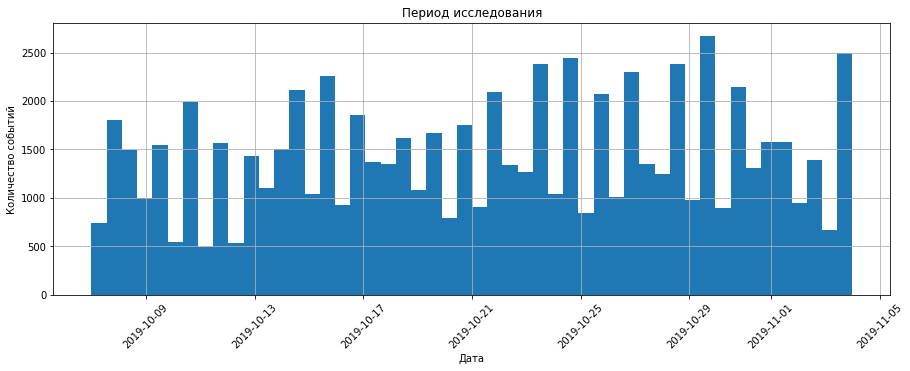

In [21]:
df['event_time'].hist(bins=50) #строим гистограмму распределения 
plt.xticks(rotation=45)
rcParams['figure.figsize'] = 15, 5
plt.title("Период исследования")
plt.xlabel("Дата")
plt.ylabel("Количество событий")
plt.show()

Судя по гистограмме все данные за расматриваемый период полные.

Далее выделим сессии пользователей, чтобы точнее рассчитывать временные метрики. Выделять сессии будем относительно тайм-аута, временной порог установим 20 минут, так как в целом, по моему мению, этого времени достаточно для завершения одногй сессии. Также я рассматривала вариант в длительностью сессии в 30 минут и 40 минут, результат практически не отличался. Поэтому было принято решение учитывать одну сессию за 20 минут.

In [22]:
df = df.sort_values(['user_id', 'event_time']) #сортируем датасет 
#определяем разницу 20 минут для каждой группы с кумулятивной суммой
g = (df.groupby('user_id')['event_time'].diff() > pd.Timedelta('20Min')).cumsum()
#создаем счетчик групп
df['session_id'] = df.groupby(['user_id', g], sort=False).ngroup() + 1
df.head()

,event_time,event_name,user_id,source,date,session_id
791,2019-10-07 13:39:45,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,1
792,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,1
795,2019-10-07 13:41:05,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,1
806,2019-10-07 13:43:20,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,1
815,2019-10-07 13:45:30,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,1


На этапе исследовательского анализа данных мы объединили события `show_contacts` и `contacts_show` в одно, так как они имеют одинановое значение, также объединили 7 разных событий `search`, так как мы не знаем точные действия, которые совершают пользователи под этими событиями. Выявили, что чаще всего пользователи совершают действие `tips_show` - более 50% от всех событий в логе. Данное событие совершается автоматически, насколько нам известно из описания данных, на этом этапе не понятно, стоит ли их учитывать при расчетах.

Также мы проверили распределение событий по пользователям, выяснили, что есть пользователи с большим количеством событий, максимальное значение - 478 событий, минимальное - 1 событие на пользователя.
Данные нам предоставлены за мериод с 7 октября по 3 ноября 2019 года.

## Сегментация пользователей на основе действий

### Сегментация пользователей и расчет метрики Retention Rate

Для подсчета метрик разделим пользователей по источникам и получим 3 группы пользователей. Проверим, будет ли различие в метриках для пользователей, пришедших из разных источников, возможно, мы найдем признаки, которые будут полезны заказчику. 

In [23]:
df.groupby('source').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False).reset_index()

,source,user_id
0,yandex,1904
1,other,1205
2,google,1117


Пользоватей, пришедших по каналу `yandex` у нас больше, но не намного, поэтому можем провести такую сегментацию для проверки метрик.

Добавим столбцы с максимальной и минимальной датой события, совершенного пользователем, чтобы рассчитать лайфтайм.

In [24]:
user_min = df.groupby('user_id')['date'].min().reset_index()
user_max = df.groupby('user_id')['date'].max().reset_index()
user = df.merge(user_min, on='user_id')
user = user.merge(user_max, on='user_id')
user.rename(columns = {'date_x':'date', 'date_y':'date_min', 'date':'date_max'}, inplace = True)

In [25]:
# делим данные по источнику для расчета  RR
google = user[user['source'] =='google']
yandex = user[user['source'] =='yandex']
other = user[user['source'] =='other']

In [26]:
# задаём момент и горизонт анализа данных
observation_date = datetime(2019, 11, 3).date()
horizon_days = 7

За момент анализа будем считать 03.11.2019 - дату окончания сбора лога. Горизонт анализа зададим 7 дней.
Для расчета Retention Rate создадим функцию, возвращающую таблицу удержания.

In [27]:
def get_retention(
    user, observation_date, horizon_days, ignore_horizon=False
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = user.query('date <= @last_suitable_acquisition_date')

    
    result_raw['lifetime'] = (
        result_raw['date_max'] - result_raw['date_min']
    ).dt.days

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=['date'], columns='lifetime', values='user_id', aggfunc='nunique'
    )
    cohort_sizes = (
        result_raw.groupby('date')
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on='date', how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания
    return result_raw, result_grouped

In [28]:
retention_raw, retention_google = get_retention(
    google, observation_date, horizon_days
)
retention_google

,cohort_size,0,1,2,3,4,5,6
date,,,,,,,,
2019-10-07,55,0.490909,0.072727,0.036364,0.036364,0.036364,0.000000,0.018182
2019-10-08,51,0.411765,0.156863,0.078431,0.058824,0.019608,0.000000,0.000000
2019-10-09,60,0.466667,0.083333,0.083333,0.050000,0.050000,0.000000,0.050000
2019-10-10,48,0.437500,0.062500,0.104167,0.104167,0.020833,0.000000,0.020833
2019-10-11,49,0.489796,0.040816,0.020408,0.061224,0.061224,0.000000,0.020408
2019-10-12,44,0.386364,0.045455,0.045455,0.022727,0.068182,0.022727,0.045455
2019-10-13,48,0.479167,0.125000,0.041667,0.020833,0.104167,0.000000,0.020833
2019-10-14,67,0.313433,0.104478,0.059701,0.014925,0.044776,0.014925,0.029851
2019-10-15,69,0.405797,0.086957,0.057971,0.028986,0.086957,0.014493,0.072464


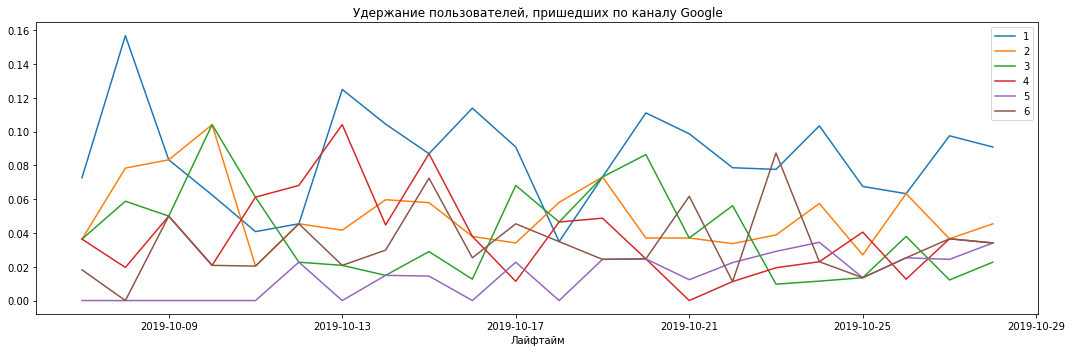

In [29]:
retention_google.drop(columns=['cohort_size', 0]).plot()
plt.legend()
plt.xlabel('Лайфтайм')
plt.title('Удержание пользователей, пришедших по каналу Google')
plt.tight_layout()
plt.show() 

In [30]:
retention_raw, retention_yandex = get_retention(
    yandex, observation_date, horizon_days
)
retention_yandex

,cohort_size,0,1,2,3,4,5,6
date,,,,,,,,
2019-10-07,88,0.443182,0.068182,0.022727,0.034091,0.034091,0.022727,0.011364
2019-10-08,91,0.494505,0.120879,0.032967,0.021978,0.021978,0.000000,0.000000
2019-10-09,105,0.485714,0.076190,0.076190,0.019048,0.019048,0.028571,0.009524
2019-10-10,109,0.431193,0.091743,0.018349,0.064220,0.036697,0.045872,0.009174
2019-10-11,107,0.355140,0.065421,0.112150,0.018692,0.046729,0.056075,0.018692
2019-10-12,86,0.348837,0.058140,0.093023,0.034884,0.046512,0.069767,0.023256
2019-10-13,117,0.376068,0.102564,0.059829,0.034188,0.025641,0.051282,0.025641
2019-10-14,140,0.357143,0.092857,0.042857,0.035714,0.050000,0.064286,0.007143
2019-10-15,142,0.338028,0.070423,0.028169,0.042254,0.000000,0.077465,0.021127


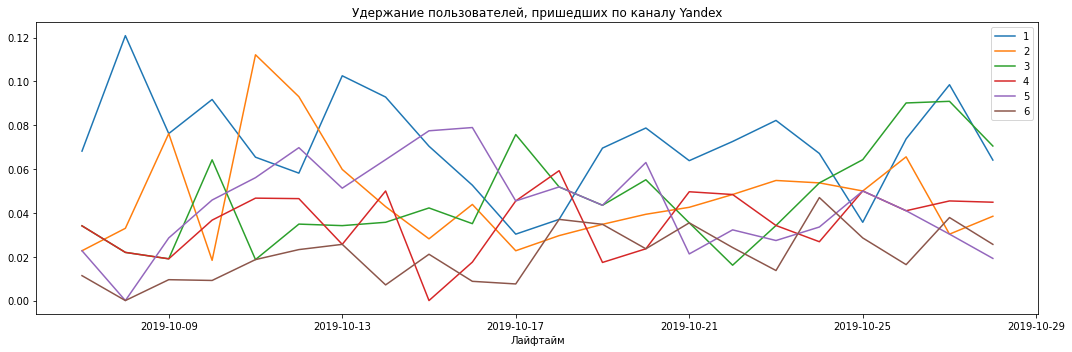

In [31]:
retention_yandex.drop(columns=['cohort_size', 0]).plot()
plt.legend()
plt.xlabel('Лайфтайм')
plt.title('Удержание пользователей, пришедших по каналу Yandex')
plt.tight_layout()
plt.show()

In [32]:
retention_raw, retention_other = get_retention(
    other, observation_date, horizon_days
)
retention_other

,cohort_size,0,1,2,3,4,5,6
date,,,,,,,,
2019-10-07,58,0.500000,0.051724,0.051724,0.034483,0.000000,0.017241,0.017241
2019-10-08,60,0.516667,0.116667,0.033333,0.050000,0.016667,0.050000,0.033333
2019-10-09,60,0.366667,0.116667,0.050000,0.033333,0.000000,0.033333,0.016667
2019-10-10,76,0.421053,0.078947,0.000000,0.065789,0.013158,0.013158,0.026316
2019-10-11,47,0.361702,0.063830,0.000000,0.106383,0.063830,0.042553,0.042553
2019-10-12,47,0.297872,0.085106,0.000000,0.085106,0.021277,0.042553,0.021277
2019-10-13,56,0.303571,0.107143,0.017857,0.071429,0.017857,0.053571,0.053571
2019-10-14,88,0.329545,0.045455,0.034091,0.034091,0.045455,0.034091,0.045455
2019-10-15,88,0.352273,0.045455,0.056818,0.056818,0.045455,0.034091,0.034091


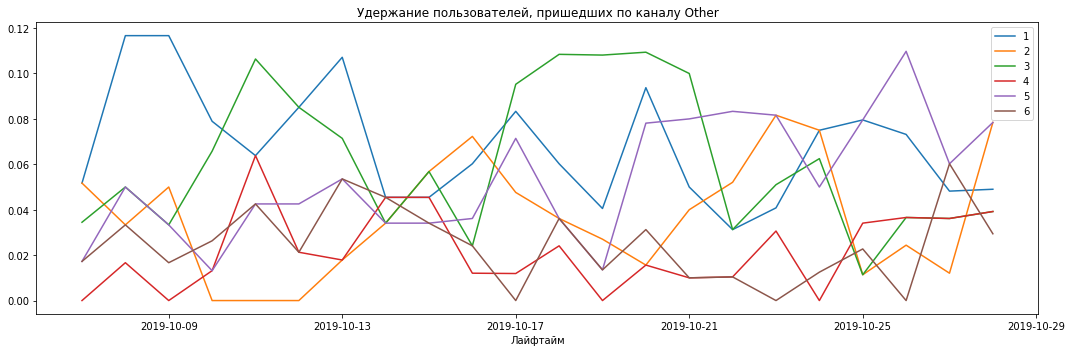

In [33]:
retention_other.drop(columns=['cohort_size', 0]).plot()
plt.legend()
plt.xlabel('Лайфтайм')
plt.title('Удержание пользователей, пришедших по каналу Other')
plt.tight_layout()
plt.show()

По табличкам удержания и графикам в целом можно сказать, что пользователи, пришедшие по каналу Google удерживаются несколько лучше, чем Yandex и Other.

### Расчет времени, проведённого в приложении

На основании выделенных id сессий можем вычислить время, проведенное в приложении для выделенных групп, руководствуясь временем совершения следующего события.

In [34]:
df['diff'] = df.groupby(['session_id'])['event_time'].diff(1)
df['diff'] = df.groupby(['session_id'])['diff'].shift(-1)
df['diff'] = df['diff'] / np.timedelta64(1, 's')
df.head()

,event_time,event_name,user_id,source,date,session_id,diff
791,2019-10-07 13:39:45,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,1,46.0
792,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,1,34.0
795,2019-10-07 13:41:05,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,1,135.0
806,2019-10-07 13:43:20,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,1,130.0
815,2019-10-07 13:45:30,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,1,13.0


In [35]:
round(df.groupby('source').agg({'user_id' : 'nunique', 'diff': 'mean'}).reset_index(),2)

,source,user_id,diff
0,google,1117,114.24
1,other,1205,110.98
2,yandex,1904,117.28


Мы рассчитали для каждого пользователя суммарное время в приложении и в разрезе групп. Больше всего времени в приложении проводят пользователи, пришедшие по источнику yandex, далее следуют google и other с небольшим отрывом. 

Посмотрим сколько всего сессий у пользователей для каждого источника.

In [36]:
df.groupby('source')['session_id'].nunique().to_frame()

,session_id
source,
google,3000
other,3135
yandex,4773


Больше всего сессий у пользователей, пришедших по источнику yandex, далее следует other и google.

### Расчет частоты действий пользователей в приложении

Посчитаем частоту действий поьзователей в разбивке по каналам привлечения.

In [37]:
event_google = df.query('source == "google"')
events_g = event_google.groupby('event_name')['user_id'].count().reset_index()
events_g['%_events'] = (events_g['user_id'] / events_g['user_id'].sum()*100).round(2)
events_g

,event_name,user_id,%_events
0,advert_open,1619,8.05
1,contacts_call,161,0.80
2,contacts_show,1394,6.93
3,favorites_add,413,2.05
4,map,983,4.88
5,photos_show,3309,16.44
6,search,2117,10.52
7,tips_click,190,0.94
8,tips_show,9937,49.38


In [38]:
event_yandex = df.query('source == "yandex"')
events_y = event_yandex.groupby('event_name')['user_id'].count().reset_index()
events_y['%_events'] = (events_y['user_id'] / events_y['user_id'].sum()*100).round(2)
events_y

,event_name,user_id,%_events
0,advert_open,2612,7.73
1,contacts_call,222,0.66
2,contacts_show,1975,5.85
3,favorites_add,742,2.20
4,map,1863,5.51
5,photos_show,3462,10.25
6,search,2648,7.84
7,tips_click,393,1.16
8,tips_show,19872,58.81


In [39]:
event_other = df.query('source == "other"')
events_o = event_other.groupby('event_name')['user_id'].count().reset_index()
events_o['%_events'] = (events_o['user_id'] / events_o['user_id'].sum()*100).round(2)
events_o

,event_name,user_id,%_events
0,advert_open,1914,10.08
1,contacts_call,151,0.79
2,contacts_show,1001,5.27
3,favorites_add,259,1.36
4,map,886,4.66
5,photos_show,2576,13.56
6,search,1911,10.06
7,tips_click,228,1.20
8,tips_show,10068,53.01


Видно, что целевое действие `contacts_show` чаще совершают пользователи, пришедшие по каналу google - 6,93% от общего числа событий, в то время как у пользователей yandex (5,85%) и other (5,27%) эти показатели ниже. Во всех трех группах чаще всего совершают событие `tips_show`.

###    Расчет конверсии в целевое действие

Посчитаем конверсию в целевое действие `contacts_show` по формуле Количество просмотров контактов (`contacts_show`) / Количество уникальных пользователей в группе * 100

In [40]:
# делим данные по источнику и целевому событию contacts_show
google_contacts_show = google[google['event_name'] =='contacts_show']
yandex_contacts_show = yandex[yandex['event_name'] =='contacts_show']
other_contacts_show = other[other['event_name'] =='contacts_show']

In [41]:
#расчет конверсии пользователей, пришедших по источнику google
google_convertion = (
    (len(google_contacts_show.groupby('user_id')['event_name'].count()) / google['user_id'].nunique()) * 100
)
print("Конверсия пользователей, пришедших по источнику google:", round(google_convertion, 2))

Конверсия пользователей, пришедших по источнику google: 24.53


In [42]:
#расчет конверсии пользователей, пришедших по источнику yandex
yandex_convertion = (
    (len(yandex_contacts_show.groupby('user_id')['event_name'].count()) / yandex['user_id'].nunique()) * 100
)
print("Конверсия пользователей, пришедших по источнику yandex:", round(yandex_convertion, 2))

Конверсия пользователей, пришедших по источнику yandex: 25.0


In [43]:
#расчет конверсии пользователей, пришедших по источнику other
other_convertion = (
    (len(other_contacts_show.groupby('user_id')['event_name'].count()) / other['user_id'].nunique()) * 100
)
print("Конверсия пользователей, пришедших по источнику other:", round(other_convertion, 2))

Конверсия пользователей, пришедших по источнику other: 18.67


По нашим расчетам конверсия в целевое действие почти на одном уровне у пользователей, пришедших по каналу `yandex`и `google`, и несколько меньше у `other`.

## Проверка статистических гипотез. 

1. Некоторые пользователи установили приложение по ссылке из `yandex`, другие — из `google`. Проверить гипотезу: две эти группы демонстрируют разную конверсию в просмотры контактов.

In [44]:
successful_google = google.query('event_name == "contacts_show"')
successful_yandex = yandex.query('event_name == "contacts_show"')
print('Количество пользователей, совершивших целевое действие google:' ,successful_google['user_id'].nunique())
print('Количество пользователей, совершивших целевое действие yandex:', successful_yandex['user_id'].nunique())

Количество пользователей, совершивших целевое действие google: 274
Количество пользователей, совершивших целевое действие yandex: 476


Далее сравним доли пользователей, совершивших целевое действие с помощью Z-теста.

**Нулевая гипотеза** будет звучать так - между долями групп, установивших приложение по ссылке из `yandex` и `google` значимой разницы нет.

**Альтернативная**  - между долями групп, установивших приложение по ссылке из `yandex` и `google` есть значимая разница.

Зададим критический уровень статистической значимости **alpha = .05**

Подготовим таблички с необходимыми данными для проверки гипотез - количество уникальных пользователей по источникам и количество пользователей, совершивших целевое действие.

In [45]:
#выделяем количество уникальных пользователей по источникам
nunique_users = df.groupby('source')['user_id'].nunique().to_frame().reset_index() 
nunique_users

,source,user_id
0,google,1117
1,other,1205
2,yandex,1904


In [46]:
#выделяем количество пользователей, совершивших целевое действие по источникам
successful_users = df.query('event_name == "contacts_show"').groupby('source')['user_id'].nunique().to_frame().reset_index()
successful_users

,source,user_id
0,google,274
1,other,225
2,yandex,476


In [47]:
alpha = 0.05  # критический уровень статистической значимости

purchases = successful_users.loc[0, 'user_id'], successful_users.loc[2, 'user_id']
users = nunique_users.loc[0, 'user_id'], nunique_users.loc[2, 'user_id']

p1 = purchases[0]/users[0] 
p2 = purchases[1]/users[1]
p_combined = (purchases[0] + purchases[1]) / (users[0] + users[1])
difference = p1 - p2 
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/users[0] + 1/users[1]))

distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.7728335659696379
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


2. Проверить гипотезу: у группы пользователей, которые открыли карту размещенных объявлений `map` конверсия в целевое действие выше.

In [48]:
map_event = df.loc[(df['event_name'] == 'map')]
contacts_show_event = df.loc[(df['event_name'] == 'contacts_show')]

map_users = map_event['user_id'].to_list()
contacts_users = contacts_show_event['user_id'].to_list()

In [49]:
#выделяем количество пользователей, совершивших целевое действие и открывших map по источникам
successful_users_map = df.query('user_id in @map_users and user_id in @contacts_users').groupby('source')['user_id'].nunique().to_frame().reset_index()
successful_users_map

,source,user_id
0,google,75
1,other,68
2,yandex,146


In [50]:
#выделяем количество уникальных пользователей, совершивших целевое действие по источникам
nunique_users_map = df.query('event_name == "contacts_show"').groupby('source')['user_id'].nunique().to_frame().reset_index() 
nunique_users_map

,source,user_id
0,google,274
1,other,225
2,yandex,476


Проверим группы `yandex` и `google`:

**Нулевая гипотеза** будет звучать так - между долями групп, установивших приложение по ссылке из `yandex` и `google`, и которые открыли карту размещенных объявлений `map` значимой разницы нет.

**Альтернативная**  - между долями групп, установивших приложение по ссылке из `yandex` и `google`, и которые открыли карту размещенных объявлений `map` есть значимая разница.

Зададим критический уровень статистической значимости **alpha = .05**

In [51]:
alpha = 0.05  # критический уровень статистической значимости

purchases1 = successful_users_map.loc[0, 'user_id'], successful_users_map.loc[2, 'user_id']
users1 = nunique_users_map.loc[0, 'user_id'], nunique_users_map.loc[2, 'user_id']

p3 = purchases1[0]/users1[0] 
p4 = purchases1[1]/users1[1]
p_combined = (purchases1[0] + purchases1[1]) / (users1[0] + users1[1])
difference = p3 - p4 
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/users1[0] + 1/users1[1]))

distr = st.norm(0, 1) 

p_value1 = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value1)

if p_value1 < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.3398036649620355
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим группы `yandex` и `other`:

**Нулевая гипотеза** будет звучать так - между долями групп, установивших приложение по ссылке из `yandex` и `other`, и которые открыли карту размещенных объявлений `map` значимой разницы нет.

**Альтернативная**  - между долями групп, установивших приложение по ссылке из `yandex` и `other`, и которые открыли карту размещенных объявлений `map` есть значимая разница.

Зададим критический уровень статистической значимости **alpha = .05**

In [52]:
alpha = 0.05  # критический уровень статистической значимости

purchases2 = successful_users_map.loc[1, 'user_id'], successful_users_map.loc[2, 'user_id']
users2 = nunique_users_map.loc[1, 'user_id'], nunique_users_map.loc[2, 'user_id']

p5 = purchases2[0]/users2[0] 
p6 = purchases2[1]/users2[1]
p_combined = (purchases2[0] + purchases2[1]) / (users2[0] + users2[1])
difference = p5 - p6 
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/users2[0] + 1/users2[1]))

distr = st.norm(0, 1) 

p_value2 = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value2)

if p_value2 < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.9038553963077005
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим группы `google` и `other`:

**Нулевая гипотеза** будет звучать так -между долями групп, установивших приложение по ссылке из `google` и `other`, и которые открыли карту размещенных объявлений `map` значимой разницы нет.

**Альтернативная**  - между долями групп, установивших приложение по ссылке из `google` и `other`, и которые открыли карту размещенных объявлений `map` есть значимая разница.

Зададим критический уровень статистической значимости **alpha = .05**

In [53]:
alpha = 0.05  # критический уровень статистической значимости

purchases3 = successful_users_map.loc[0, 'user_id'], successful_users_map.loc[1, 'user_id']
users3 = nunique_users_map.loc[0, 'user_id'], nunique_users_map.loc[1, 'user_id']

p7 = purchases3[0]/users3[0] 
p8 = purchases3[1]/users3[1]
p_combined = (purchases3[0] + purchases3[1]) / (users3[0] + users3[1])
difference = p7 - p8 
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/users3[0] + 1/users3[1]))

distr = st.norm(0, 1) 

p_value3 = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value3)

if p_value3 < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.48356038905768495
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Мы не обнаружили статистически значимой разницы конверсии в просмотры контактов между пользователями, установившими приложение по ссылке из `yandex` и `google`.

Также гипотеза о более высокой конверсии у группы пользователей, которые открыли карту размещенных объявлений `map` не подтвердилась. 

## Выводы и рекомендации. 

В ходе исследования мы выделили три группы пользователей - по источнику привлечения. Для каждой группы были рассчитаны метрики retention rate и конверсия в целевое действие. Удалось установить, что retention rate для пользователей, пришедших по каналу Google удерживаются несколько лучше, чем Yandex и Other. Конверсия  в целевое действие почти на одном уровне у пользователей, пришедших по каналу yandex и google, и несколько меньше у other. Также мы выяснили, что больше всего времени в приложении проводят пользователи, пришедшие по источнику yandex, далее следуют google и other с небольшим отрывом. Целевое действие contacts_show чаще совершают пользователи, пришедшие по каналу google - 6,93% от общего числа событий, в то время как у пользователей yandex (5,85%) и other (5,27%) эти показатели ниже. Во всех трех группах чаще всего совершают событие tips_show.

При проверке гипотез мы не обнаружили статистически значимой разницы конверсии в просмотры контактов между пользователями, установившими приложение по ссылке из yandex и google.
Также гипотеза о более высокой конверсии у группы пользователей, которые открыли карту размещенных объявлений map не подтвердилась.

По результатам анализа можно рекомендовать обратить внимание на пользователей, пришедших по источнику Yandex, так как таких пользователей больше всего и времени в приложении они проводят больше, но удержание и конверсия ниже, чем у того же Google.